## Overview notebook from Ivan's Cruise (Aug 24-29)

This notebook pulls in some of the major data streams and visualizes them together along with GOES SST imagery from around the time of each transect.

In [1]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

Pull in the TSG data

This data is available every second but using the per minute one here

In [2]:
df = pd.read_csv("data/ivan_cruise/SW21009R_NRL/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  08/25/2021  12:46:24         2021             8          25    124935.70   
1  08/25/2021  12:47:25         2021             8          25    125035.70   
2  08/25/2021  12:48:25         2021             8          25    125135.70   
3  08/25/2021  12:49:25         2021             8          25    125235.69   
4  08/25/2021  12:50:25         2021             8          25    125336.69   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3433.3240           N    7610.8499           W  ...   
1   3433.4081           N    7610.6764           W  ...   
2   3433.4919           N    7610.5111           W  ...   
3   3433.5739           N    7610.3362           W  ...   
4   3433.6615           N    7610.1648           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   76.1                  5.00                 76.40   
1                   75.7                  4.49                 86.89   
2                   75.2                  3.29                 95.20   
3                   75.6                  5.29                 80.90   
4                   75.3                  2.90                 99.29   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0               10.75                  219.05          27.7042   35.6590   
1               12.15                  215.33          27.6905   35.6585   
2               11.20                  214.90          27.6949   35.6639   
3               12.10                  213.94          27.6968   35.6928   
4               11.44                  221.88          27.6971   35.6891   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    36.91                   37.88   
1                                    37.36                   38.36   
2                                    37.80                   38.80   
3                                    36.98                   37.98   
4                                    36.95                   37.95   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [3]:
len(df)

6859

The ship's computer was about 4 minutes behind so adding that here. Will fix this by using the data stamped by the GPS clock.

In [4]:
date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

In [5]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

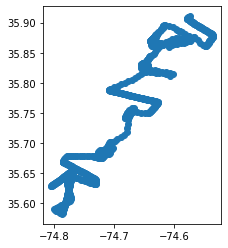

In [6]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].plot()

In [7]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

Cutting the whole dataset up into transects by visualizing them like this.

In [9]:
df.loc['2021-08-29 16:15:00':'2021-08-29 17:52:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo', width=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [10]:
df.loc['2021-08-25 23:00:00':'2021-08-27 17:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo', width=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

Pull in the CDOM data

In [11]:
! ls data/ivan_cruise/cdom/

cdom_flu_output_210825_1.txt  cdom_flu_output_210828_1.txt
cdom_flu_output_210826_1.txt  cdom_flu_output_210829_1.txt
cdom_flu_output_210827_1.txt


This is not a perfect matchup in time since sometimes there was some skipping and the arduino was recording multiple CDOM readings without a timestamp. It could be off by a few seconds or up to maybe a minute. Should be simple to fix.

In [12]:
cdom_files = [
    'data/ivan_cruise/cdom/cdom_flu_output_210825_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210826_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210827_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210828_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210829_1.txt'
             ]

cdom_dfs = []

for item in cdom_files:
    cdom_data = open(item)
    lines = cdom_data.readlines()
    sensor_values = []
    utc_times = []
    for i in range(len(lines)):
        line = lines[i]
        if "sensor" in line:
            try:
                line = line.split('= ')[1]
                line = line.replace('\n', '')
                sensor_values.append(int(line))
                if "UTC" in lines[i-1]:
                    data_time = lines[i-1][5:-2]
                    utc_times.append(data_time)
                elif "UTC" in lines[i+1]:
                    data_time = lines[i+1][5:-2]
                    utc_times.append(data_time)
            except:
                pass
    print(len(sensor_values)-len(utc_times))
    sensor_values = sensor_values[len(sensor_values)-len(utc_times):]
    utc_times = pd.to_datetime(utc_times)
    cdom_df = pd.DataFrame(np.array(sensor_values)/1024.0*5, columns = ['cdom_volts'])
    cdom_df['utc_dt'] = utc_times
    cdom_df  = cdom_df.set_index('utc_dt')
    cdom_dfs.append(cdom_df)
    
cdom_df = pd.DataFrame().append(cdom_dfs)

12
285
2
28
104


Pull in radiometer data and calculate chla based on OCI algorithm from Hu et al 2012

Worth noting that when I converted these excel sheets to csv I had to modify the column type of the timestamp to `m/d/yyyy h:mm:ss` to ensure seconds were output because their default setting cut off the seconds part of that column.

In [14]:
trios_fns = [
    'data/ivan_cruise/trios/shearwater_trios_20210826.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210827.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210828.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

Based on our notes I believe that the TriOS data was saved as local time so I convert it here to UTC. I have not included the offset compared to the inline but that is likely about 10 seconds or more.

In [15]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

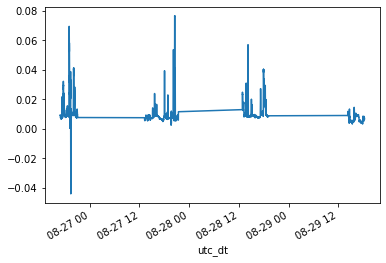

In [16]:
trios_df['400'].rolling(window=6*3).mean().plot()

In [17]:
# these are the coefficients based on the Hu et al 2012 paper

ci1 = -0.49
ci2 = 191.6590

# these are some coefficients that I calculated using the same exact method but trying to optimize for the Micasense bands

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [18]:
trios_df['chla_oci'] = oc_index(trios_df.iloc[:, 156:161].mean(axis=1).values, trios_df.iloc[:, 232:240].mean(axis=1).values, trios_df.iloc[:, 346:351].mean(axis=1).values)

Some of the values are way too high so cutting those off.

In [19]:
trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan

<ipython-input-19-07c79c7d9104>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan


(0.0, 0.4)

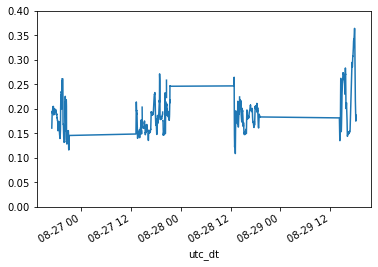

In [20]:
fig, ax = plt.subplots()
trios_df['chla_oci'].rolling(window=6*5).mean().plot(ax=ax)
ax.set_ylim(0,.4)

#### Visualizing SST from GOES

In [21]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [22]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="6H", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-08-27 11:00:00':'2021-08-29 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

## Plot each transect with data and SST satellite imagery

In [23]:
plt.rcParams.update({'font.size': 14})

I manually went through the data and found all these start and stop times based on the ships location and our logs. They could have errors in them but I tried to be very precise.

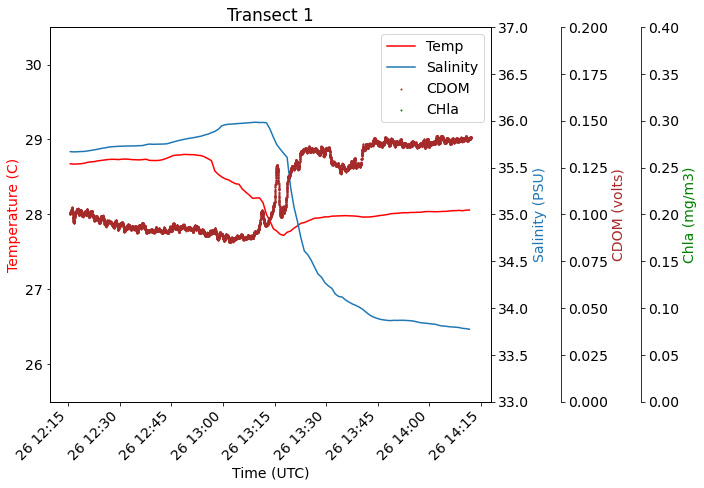

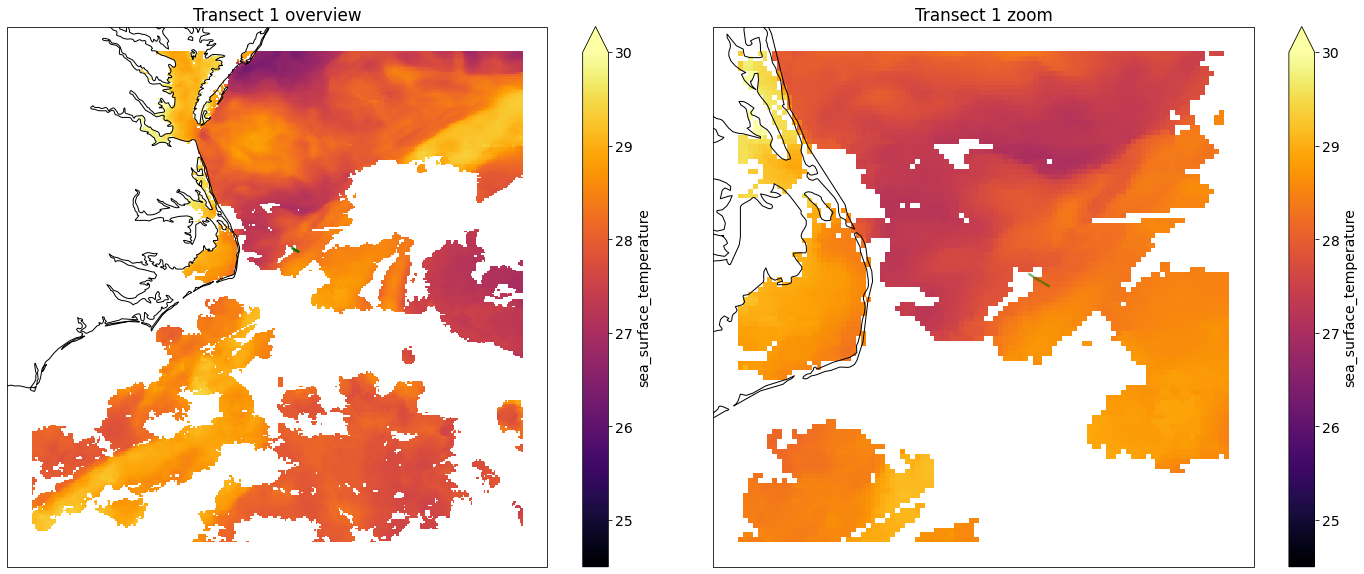

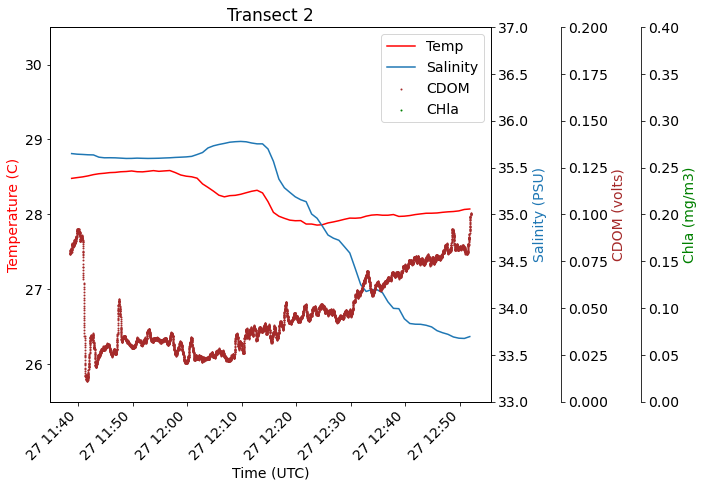

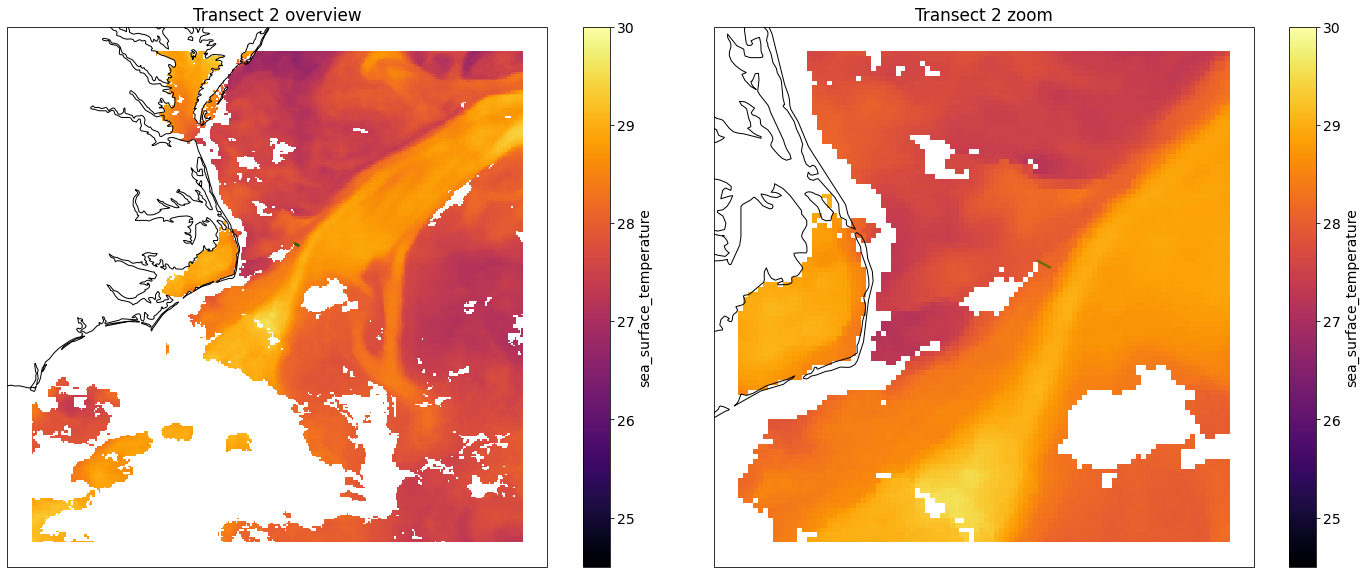

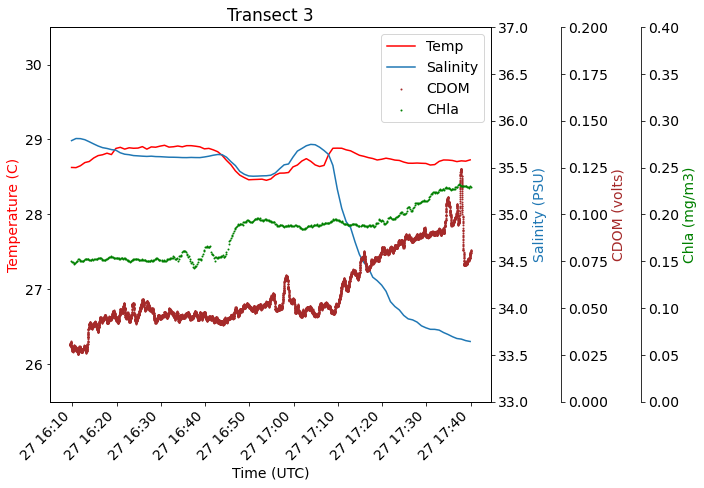

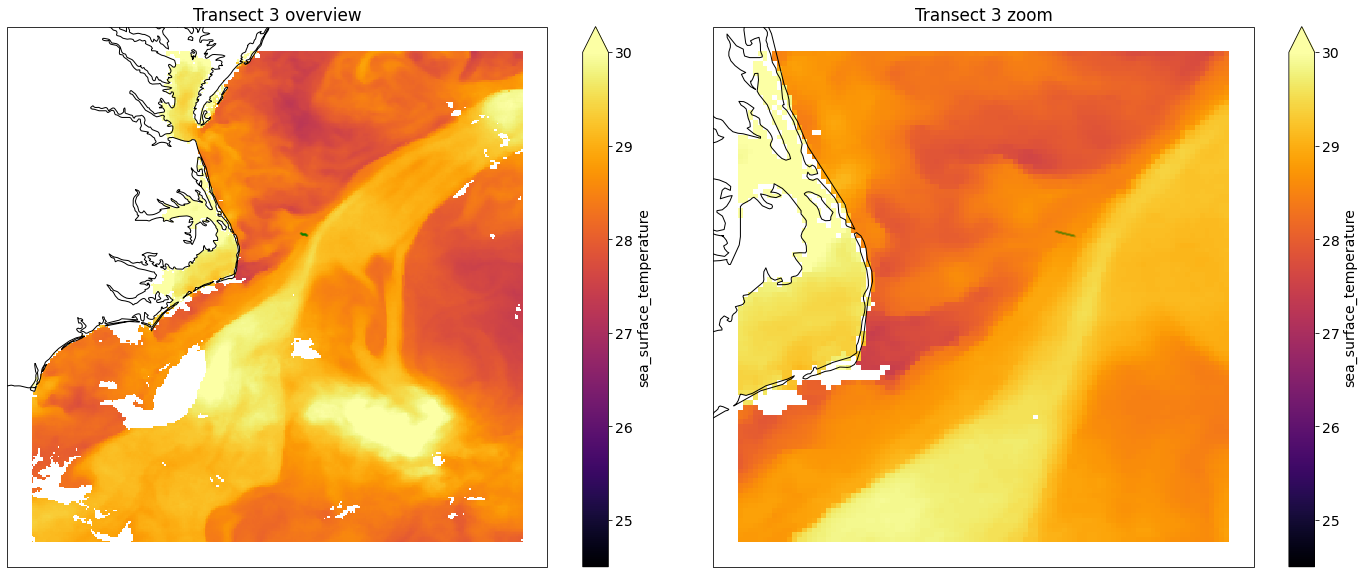

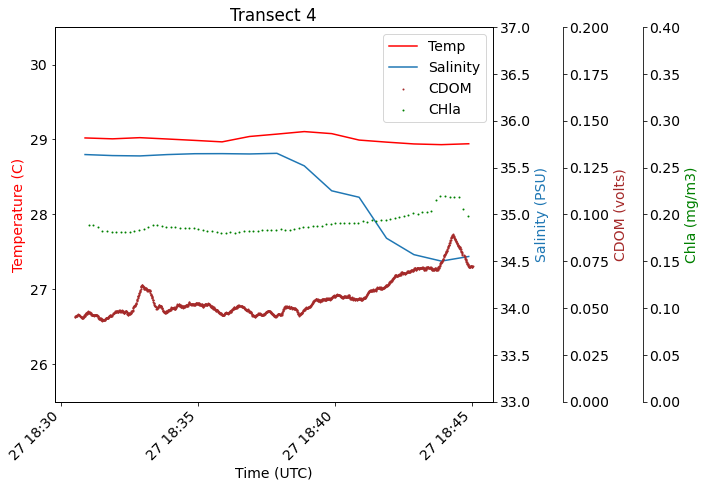

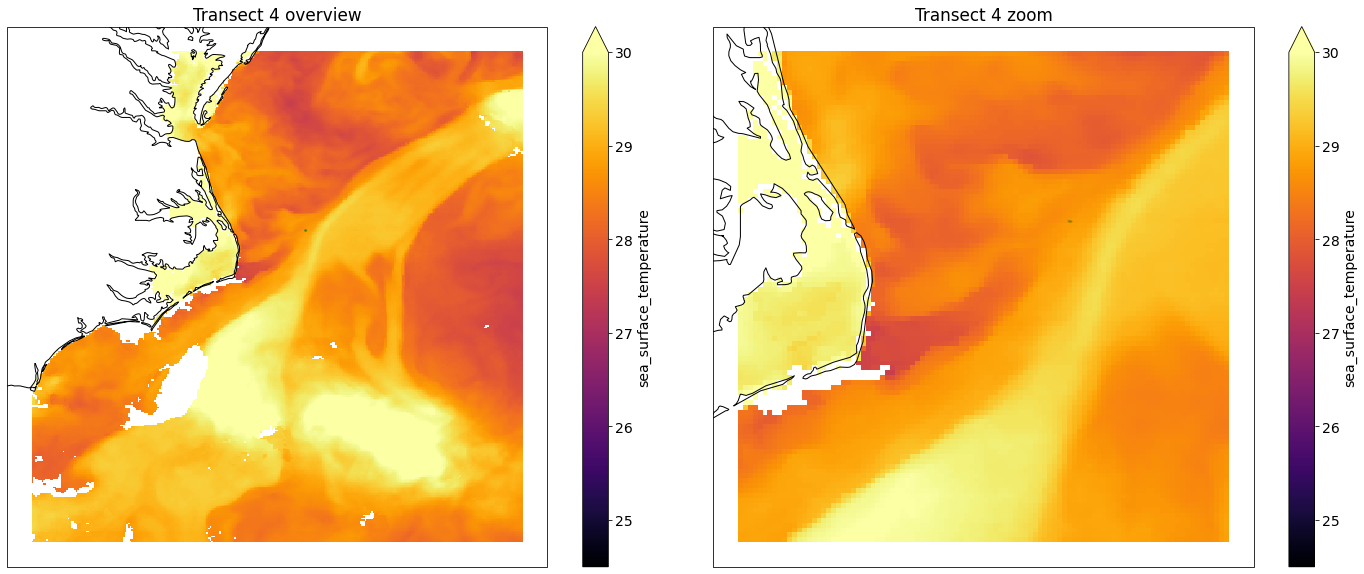

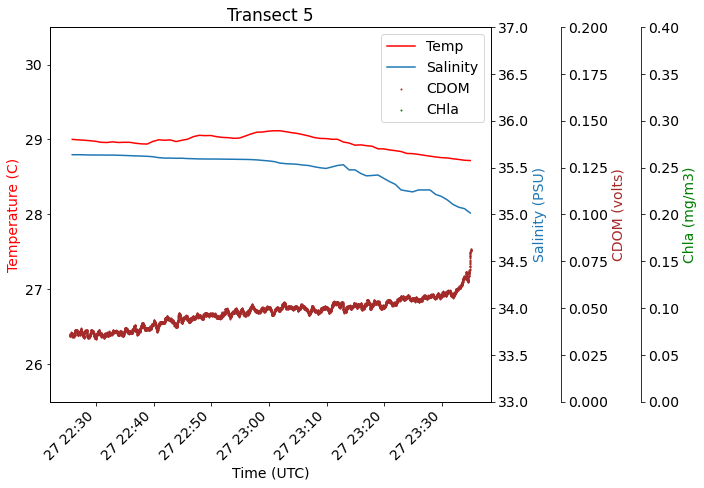

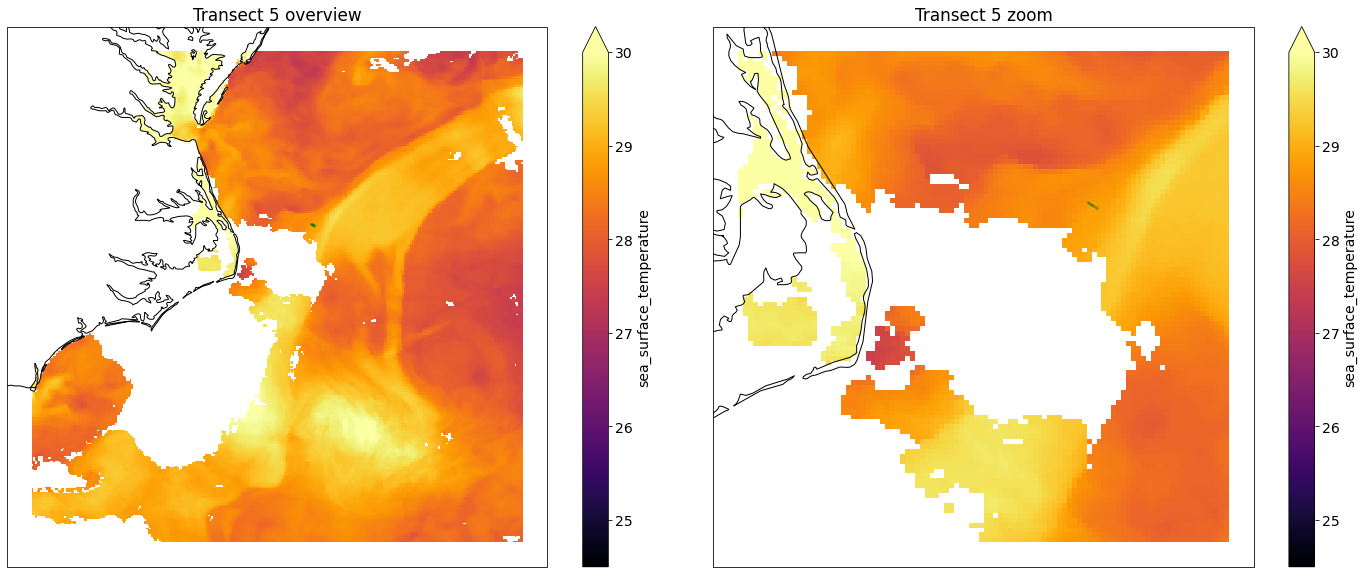

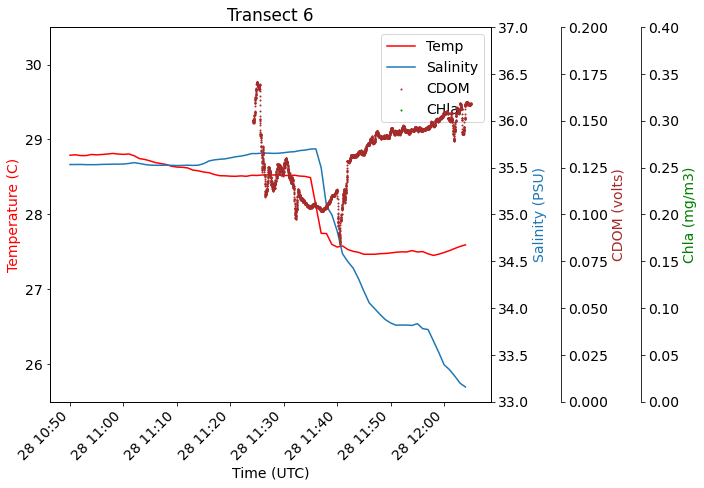

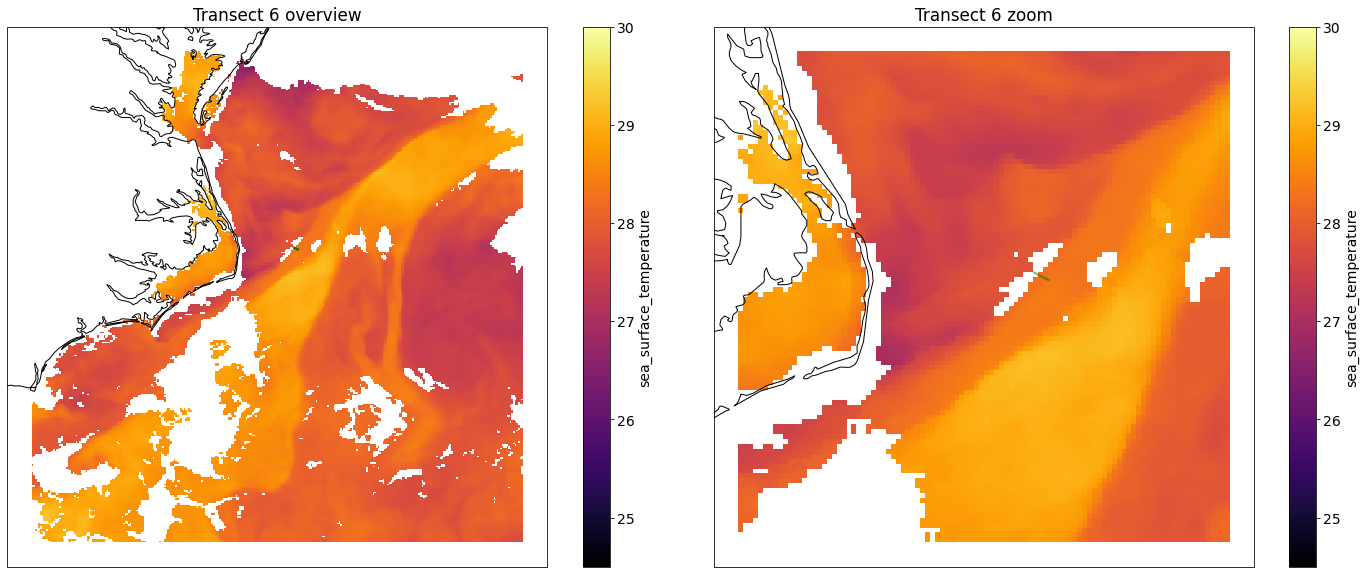

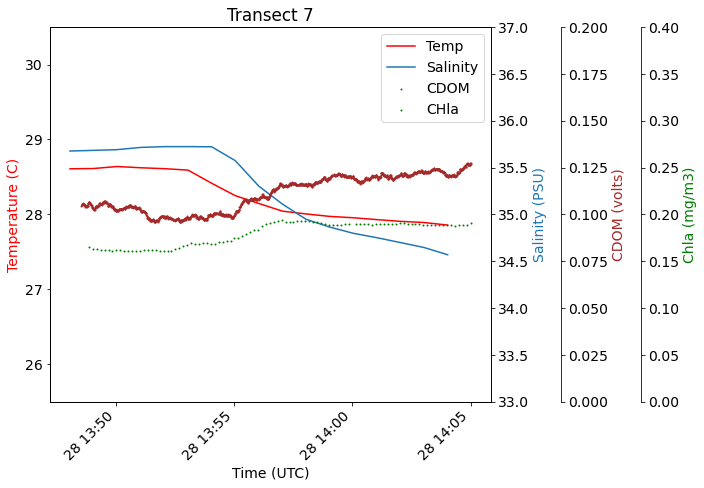

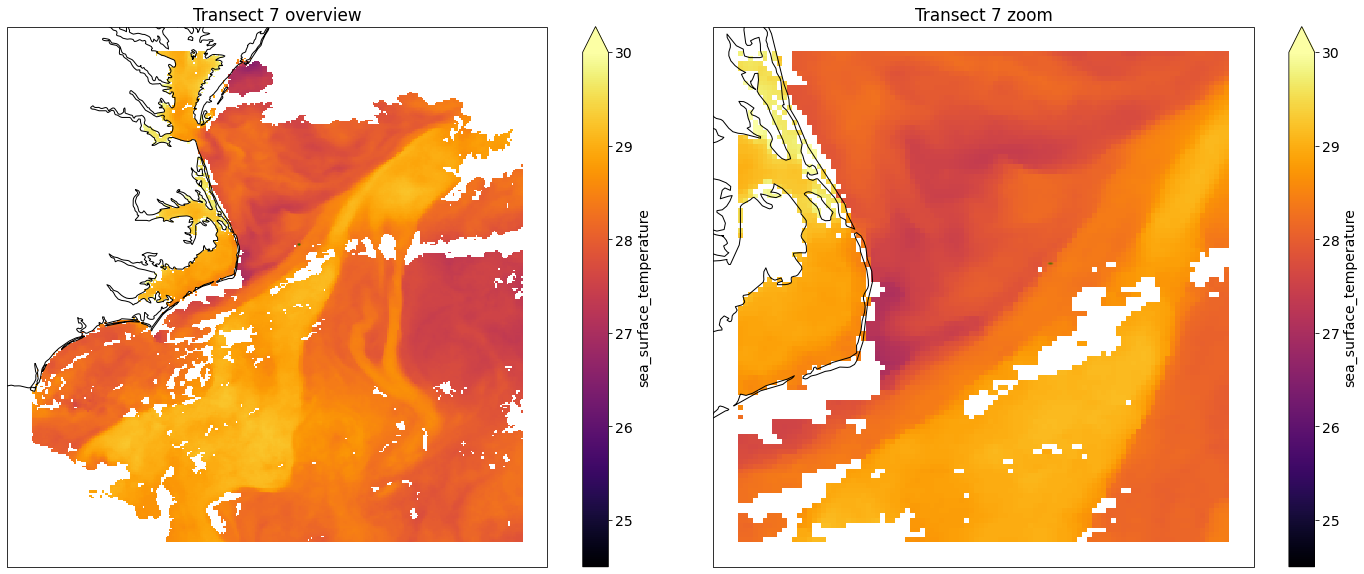

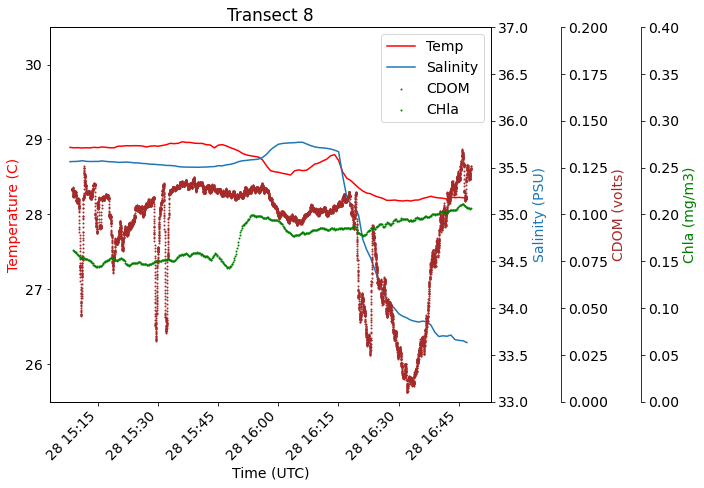

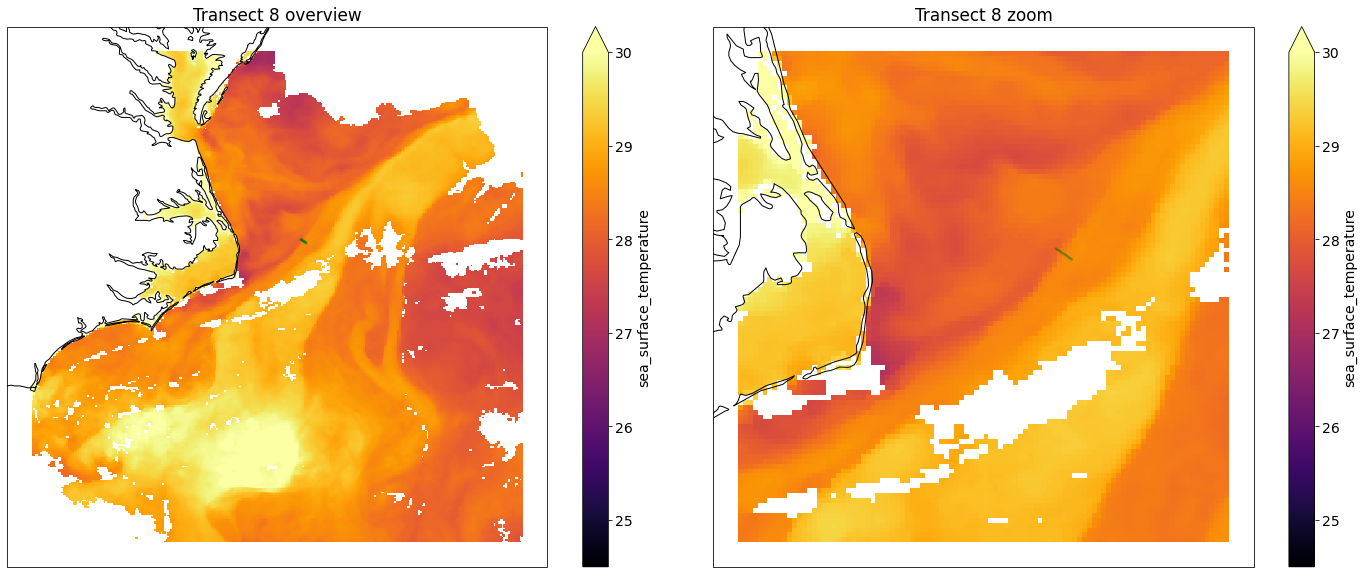

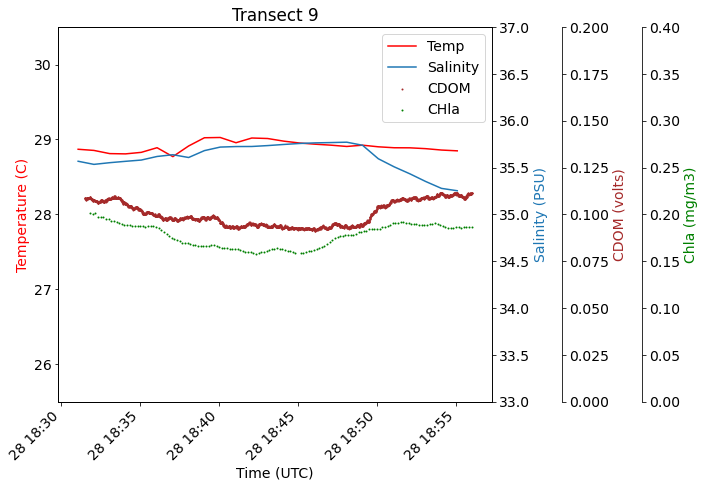

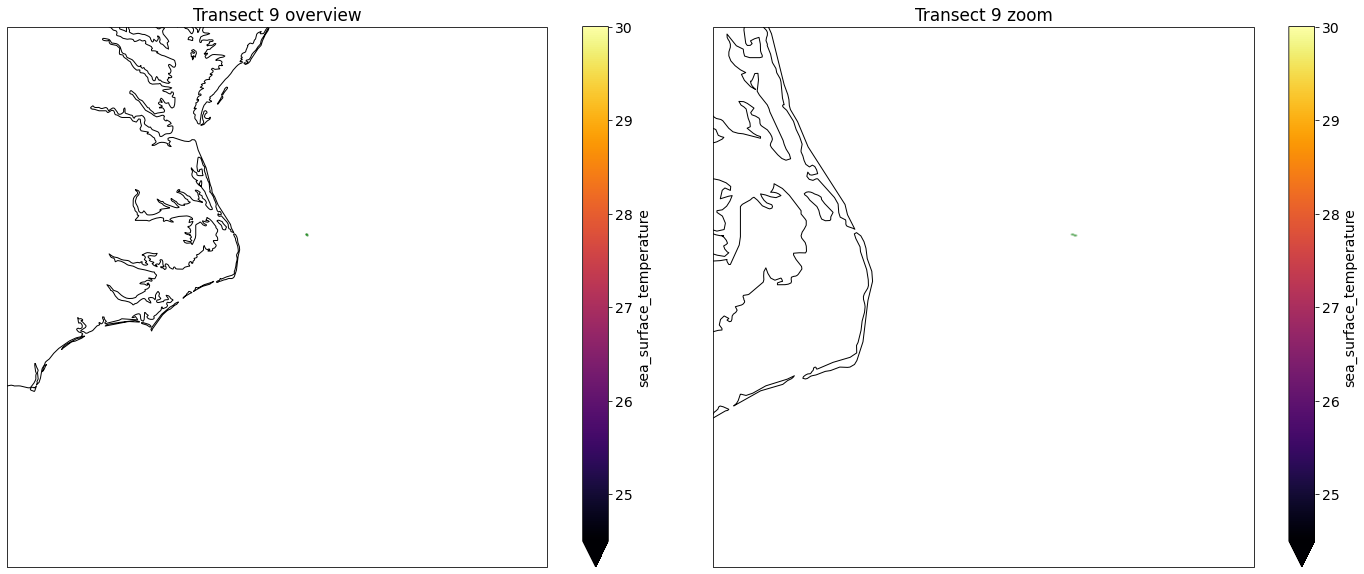

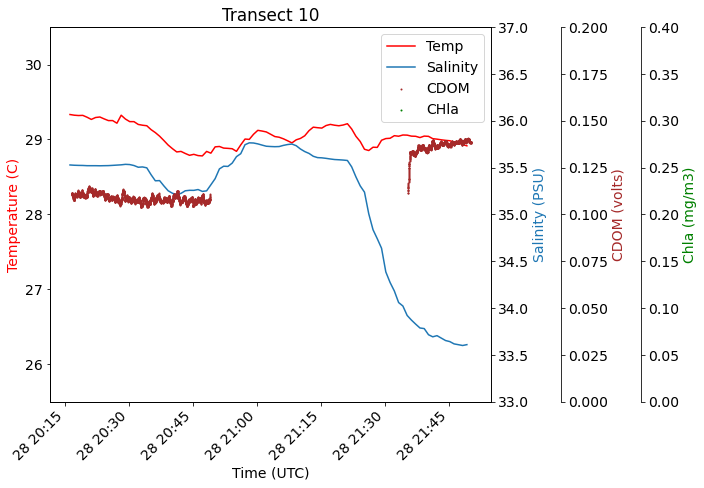

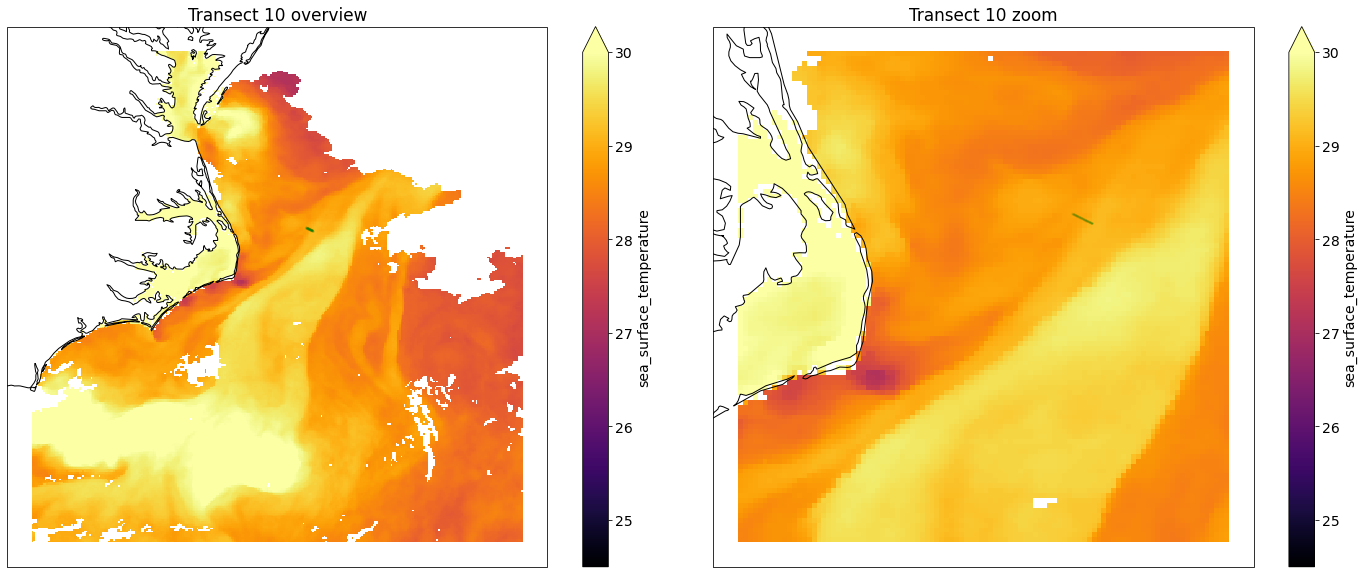

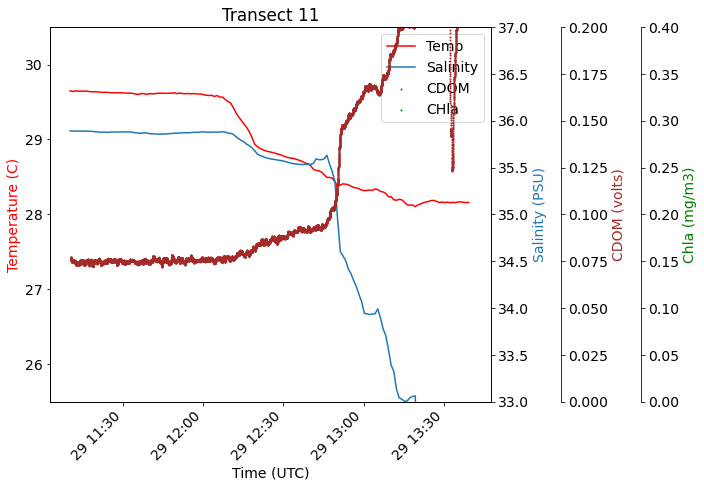

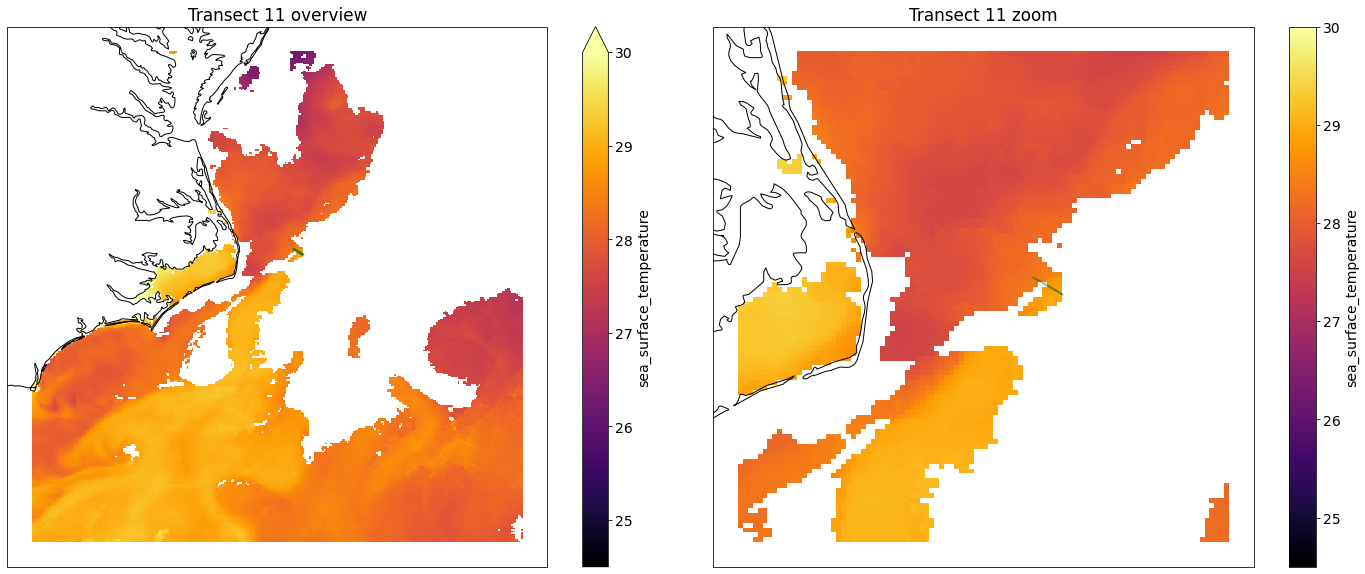

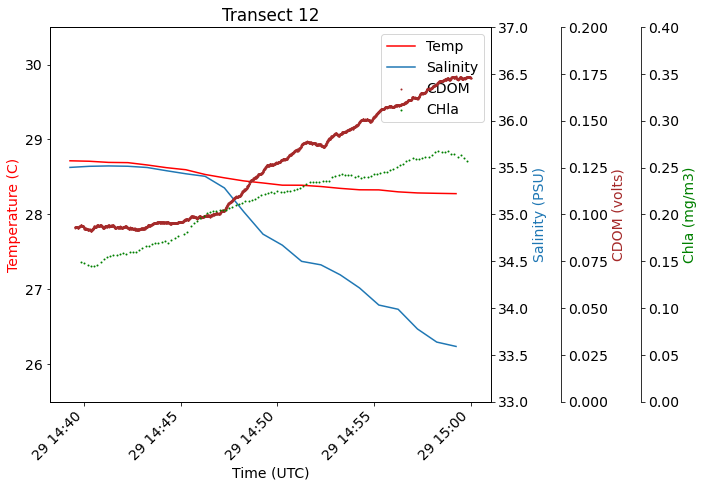

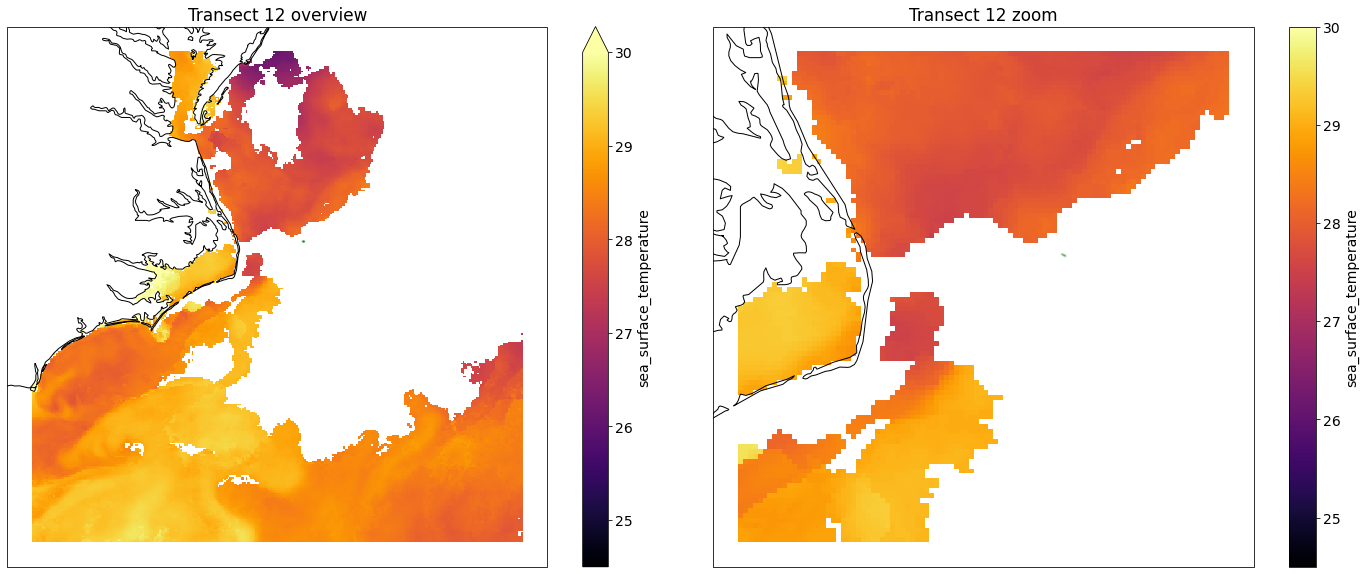

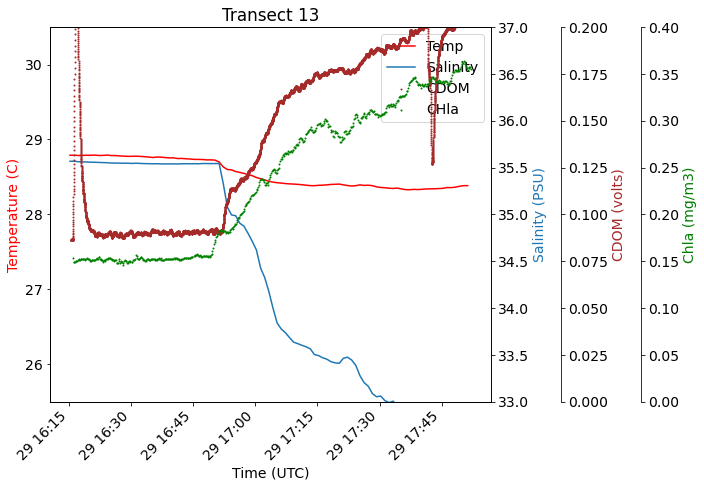

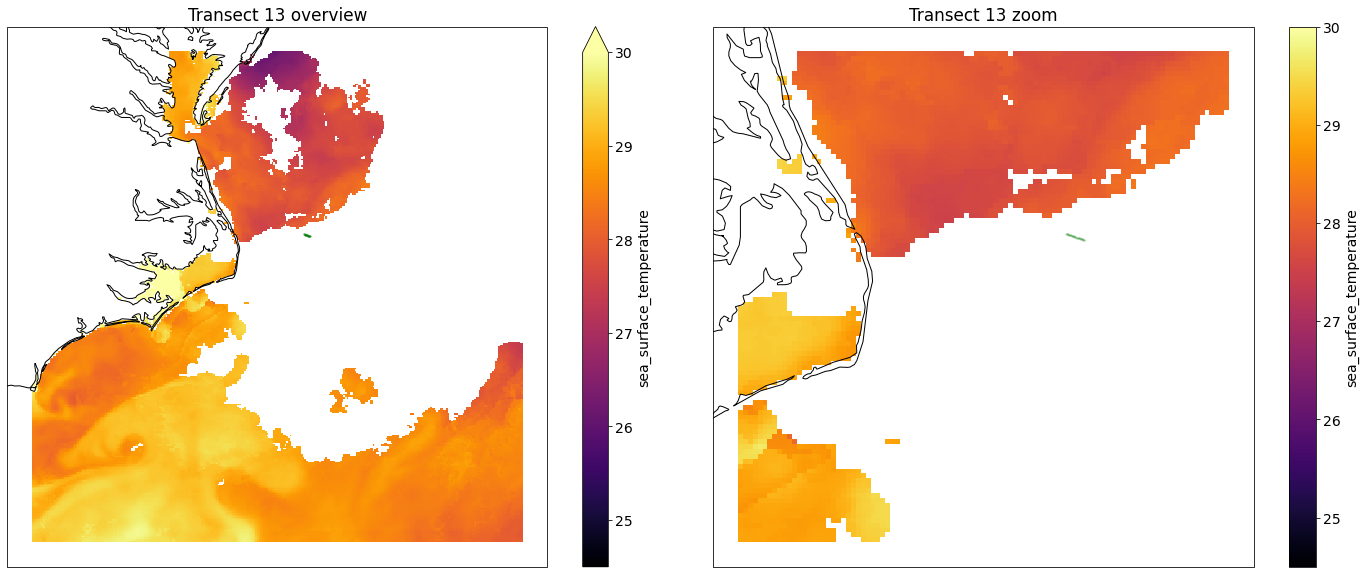

In [24]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

hours = [0,0,0,1,0,0,0,0,0,0,4,4,4]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in range(13):
    # time series plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    ax1 = ax.twinx()
    ax2 = ax.twinx()
    ax3 = ax.twinx()

    ax.set_ylim(25.5, 30.5)
    ax1.set_ylim(33, 37)
    ax2.set_ylim(.0, .20)
    ax3.set_ylim(.0, .40)

    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (C)")
    ax1.set_ylabel("Salinity (PSU)")
    ax2.set_ylabel("CDOM (volts)")
    ax3.set_ylabel("Chla (mg/m3)")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)
    
    p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp')
    p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity')
    p3  = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts'], color='brown', label='CDOM', s=1)
    
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        trios_data_x = None
        trios_data_y = None
    else:
        trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
        trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
    p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='CHla', s=1)
    
    ax.set_title(titles[i])


#     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
#     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
#     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

    lns = [p1, p2, p3, p4]
    ax.legend(handles=lns, loc='best')

    # right, left, top, bottom
    ax2.spines['right'].set_position(('outward', 70))
    
    ax3.spines['right'].set_position(('outward', 150))

    # no x-ticks                 
#     ax2.xaxis.set_ticks([])
    fig.autofmt_xdate(rotation=45)

    # Sometimes handy, same for xaxis
    #par2.yaxis.set_ticks_position('right')

    # Move "Velocity"-axis to the left
    # par2.spines['left'].set_position(('outward', 60))
    # par2.spines['left'].set_visible(True)
    # par2.yaxis.set_label_position('left')
    # par2.yaxis.set_ticks_position('left')

    ax.yaxis.label.set_color(p1.get_color())
    ax1.yaxis.label.set_color(p2.get_color())
    ax2.yaxis.label.set_color('brown')
    ax3.yaxis.label.set_color('green')

    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'.png')
#     plt.close()
    plt.show()
    
    
    
    # SST image
    
    fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
    ax[0].coastlines(resolution='10m')
    goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)
    
    ax[1].coastlines(resolution='10m')
    goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
    # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
    ax[0].set_title(titles[i] + ' overview')
    ax[1].set_title(titles[i] + ' zoom')
    fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()
    plt.show()    

    # fig.savefig('transect' + str(i) '_s_t.png')